<a href="https://colab.research.google.com/github/sebacea/AnEco2/blob/master/Complejidad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Complejidad

Este notebook introduce un ejercicio de cálculo de ventaja comparativa comunal con información extraída de [datachile.io](http://datachile.io). A través del ejercicio se pretenden responder:

- ¿Cuáles son las ventajas comparativas en productos en la comuna de Valparaíso? 
- ¿Cuáles son las comunas de Chile con mayor nivel de ventajas comparativas en áreas tecnológicas?

## Referencias

- [Glosario de términos de complejidad económica](http://atlas.cid.harvard.edu/learn/glossary)
- [Hartmann et ali - Linking Economic Complexity, Institutions, and Income Inequality (2017)](https://www.sciencedirect.com/science/article/pii/S0305750X15309876?via%3Dihub)
- [Hidalgo et ali - The Product Space Conditions the
Development of Nations (2007)](http://sci-hub.tw/10.1126/science.1144581)
- [Hidalgo and Hausmann - A Network view of economic development (2008)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.544.5939&rep=rep1&type=pdf)

## Librerías específicas

- [Product Space Calculations](https://github.com/alexandersimoes/ps_calcs/tree/master/ps_calcs)



In [0]:
import pandas as pd
import requests

Obtenemos datos desde la [API](https://es.wikipedia.org/wiki/Interfaz_de_programaci%C3%B3n_de_aplicaciones) de [DataChile](http://datachile.io). En este caso, obtenemos el valor de las Exportaciones ([FOB](https://es.wikipedia.org/wiki/Free_on_board) US) clasificados por el [sistema harmonizado](https://atlas.media.mit.edu/es/profile/country/chl/) HS0 a nivel comunal.


In [0]:
data = requests.get("https://es.datachile.io/api/data?measures=FOB US&drilldowns=HS0,Comuna,Year&captions=es&parents=true").json()

Convertimos los datos provenientes de la [API](https://es.wikipedia.org/wiki/Interfaz_de_programaci%C3%B3n_de_aplicaciones) de [DataChile](http://datachile.io) en un DataFrame que denotaremos "df"

In [0]:
df = pd.DataFrame(data["data"])

Inspeccionamos el DataFrame para tener una idea de la estructura de los datos brutos:

In [93]:
df.head()

,Comuna,FOB US,HS0,ID Comuna,ID HS0,ID Region,ID Year,Region,Year
0,Iquique,1.331382e+06,Productos de Origen Animal,113,01,1,2016,Tarapacá,2016
1,Antofagasta,4.531883e+06,Productos de Origen Animal,9,01,2,2016,Antofagasta,2016
2,Calama,9.660000e+02,Productos de Origen Animal,19,01,2,2016,Antofagasta,2016
3,Caldera,1.099919e+06,Productos de Origen Animal,21,01,3,2016,Atacama,2016
4,Copiapó,3.370124e+05,Productos de Origen Animal,68,01,3,2016,Atacama,2016


Filtramos los resultados de los datos para concentrarnos en la V región

In [0]:
df = df[df["ID Region"] == 5]

Volvemos a inspeccionar los datos, ahora filtrados para la región de Valparaíso:

In [95]:
df.head()

,Comuna,FOB US,HS0,ID Comuna,ID HS0,ID Region,ID Year,Region,Year
8,Cartagena,155358.000,Productos de Origen Animal,30,01,5,2016,Valparaíso,2016
9,Casablanca,222165.000,Productos de Origen Animal,31,01,5,2016,Valparaíso,2016
10,Con Cón,2200129.500,Productos de Origen Animal,63,01,5,2016,Valparaíso,2016
11,La Ligua,100680.000,Productos de Origen Animal,123,01,5,2016,Valparaíso,2016
12,Llay Llay,1056950.625,Productos de Origen Animal,142,01,5,2016,Valparaíso,2016


Reiniciamos el índice del DataFrame (la primera columna que no tiene etiqueta de nombre) e inspeccionamos como queda el DataFrame



In [96]:
df = df.reset_index()
df.head()

,index,Comuna,FOB US,HS0,ID Comuna,ID HS0,ID Region,ID Year,Region,Year
0,8,Cartagena,155358.000,Productos de Origen Animal,30,01,5,2016,Valparaíso,2016
1,9,Casablanca,222165.000,Productos de Origen Animal,31,01,5,2016,Valparaíso,2016
2,10,Con Cón,2200129.500,Productos de Origen Animal,63,01,5,2016,Valparaíso,2016
3,11,La Ligua,100680.000,Productos de Origen Animal,123,01,5,2016,Valparaíso,2016
4,12,Llay Llay,1056950.625,Productos de Origen Animal,142,01,5,2016,Valparaíso,2016


Calculamos la tasa de crecimiento de las exportaciones

In [0]:
tasa_crecimiento = df.sort_values(["Year", "Comuna", "HS0"]).groupby(["Comuna", "HS0"]).sum().pct_change()["FOB US"].reset_index()


Vemos el top 10 de las exportaciones con mayor tasa de crecimiento en la comuna específica de Valparaíso.

In [98]:
tasa_crecimiento[tasa_crecimiento["Comuna"] == "Valparaiso"].sort_values("FOB US", ascending=False).head(10)

,Comuna,HS0,FOB US
240,Valparaiso,Artículos de Madera,3504.916321
244,Valparaiso,Metales,2553.638074
248,Valparaiso,Pieles de animales,468.148867
258,Valparaiso,Transporte,83.169437
249,Valparaiso,Plásticos y Cauchos,17.646805
242,Valparaiso,Diverso,10.248870
252,Valparaiso,Productos alimenticios,8.793369
253,Valparaiso,Productos de Origen Animal,3.041363
250,Valparaiso,Productos Minerales,2.288546
243,Valparaiso,Instrumentos,1.704584


Definimos la función que calcula la RCA para cada comuna $c$ dentro del conjunto de comunas $C$y sector $h$ dentro del conjunto de sectores $H$ de acuerdo a la siguiente formula

$$RCA_{c,h}=\frac{\frac{FOB_{c,h}}{\sum_{h'\in H}FOB_{c,h'}}}{\frac{\sum_{c'\in C}FOB_{c',h}}{\sum_{c'\in C, h'\in H}FOB_{c',h'}}},$$

donde $RCA_{c,h}$ es la $RCA$ de la comuna $c$ para el sector $h$ y $FOB_{c,h}$ es el valor de exportaciones $FOB$ de la comuna $c$ para el sector $h$.

Se le deben entregar 4 niveles de información a la función: Producto, Nivel Geográfico, Dimensión de Tiempo y sobre qué métrica se calculará (en este caso valor FOB US de exportaciones)

In [0]:
# Importamos librería para cálculos básicos
import numpy as np
# Definimos función que calcula RCA
def rca(tbl):
  
    tbl = tbl.fillna(0)
    col_sums = tbl.sum(axis=1)

    col_sums = col_sums.values.reshape((len(col_sums), 1))
    rca_numerator = np.divide(tbl, col_sums)

    row_sums = tbl.sum(axis=0)

    total_sum = tbl.sum().sum()
    rca_denominator = row_sums / total_sum

    rcas = rca_numerator / rca_denominator
    # Entregamos RCA por comuna y clasificación HS0
    return rcas

Definimos un DataFrame para poder aplicar la función

Pivotea el DataFrame para tener una sola comuna por fila y tantas columnas como clasificaciones HS0 para poder usar la función RCA

In [100]:
df_rcas = df[df["ID Year"] == 2016][["Comuna", "HS0", "FOB US"]]
df_rcas.head()

,Comuna,HS0,FOB US
0,Cartagena,Productos de Origen Animal,155358.000
1,Casablanca,Productos de Origen Animal,222165.000
2,Con Cón,Productos de Origen Animal,2200129.500
3,La Ligua,Productos de Origen Animal,100680.000
4,Llay Llay,Productos de Origen Animal,1056950.625


In [101]:
df_rcas = df_rcas.pivot(index="Comuna", columns="HS0", values="FOB US")
df_rcas.head()

HS0,Artículos de Madera,Calzado y Sombreros,Diverso,Instrumentos,Metales,Metales preciosos,Máquinas,Piedra Y Vidrio,Pieles de animales,Plásticos y Cauchos,Productos Minerales,Productos Químicos,Productos alimenticios,Productos de Origen Animal,Productos de papel,Productos del reino vegetal,Productos derivados de animales y vegetales,Textiles,Transporte
Comuna,,,,,,,,,,,,,,,,,,,
Algarrobo,NaN,NaN,NaN,NaN,12000.000000,NaN,72000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.242650e+06,NaN,NaN,3000.0
Cabildo,NaN,NaN,NaN,NaN,NaN,NaN,24500.000000,NaN,NaN,NaN,NaN,NaN,33600.0,NaN,NaN,5.298403e+06,NaN,NaN,NaN
Calera,NaN,NaN,NaN,NaN,NaN,NaN,17500.000000,NaN,NaN,36855.0,74.0,122182.0,NaN,NaN,NaN,1.284549e+06,NaN,2.728230e+05,NaN
Cartagena,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155358.0,NaN,1.877001e+04,NaN,NaN,NaN
Casablanca,NaN,NaN,586.919983,62263.21875,8667.700195,NaN,43466.867188,6772.200195,NaN,5421227.0,NaN,999193.5,128864816.0,222165.0,25357.730469,3.978518e+05,NaN,7.963376e+06,NaN


Generamos la Matriz de RCAs para cada comuna de Valparaíso en el 2016 y vemos los resultados

In [83]:
resultados = rca(df_rcas)
resultados

HS0,Artículos de Madera,Calzado y Sombreros,Diverso,Instrumentos,Metales,Metales preciosos,Máquinas,Piedra Y Vidrio,Pieles de animales,Plásticos y Cauchos,Productos Minerales,Productos Químicos,Productos alimenticios,Productos de Origen Animal,Productos de papel,Productos del reino vegetal,Productos derivados de animales y vegetales,Textiles,Transporte
Comuna,,,,,,,,,,,,,,,,,,,
Algarrobo,0.000000,0.000000,0.000000,0.000000,1.303874,0.000000,3.018061,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.284891,0.000000,0.000000,0.017216
Cabildo,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.254928,0.000000,0.000000,0.000000,0.000000,0.000000,0.043059,0.000000,0.000000,2.418342,0.000000,0.000000,0.000000
Calera,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.562505,0.000000,0.000000,0.417795,0.000323,11.996399,0.000000,0.000000,0.000000,1.811173,0.000000,18.308791,0.000000
Cartagena,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.966273,0.000000,0.263542,0.000000,0.000000,0.000000
Casablanca,0.000000,0.000000,0.006241,0.988804,0.008695,0.000000,0.016822,1.461802,0.000000,0.739945,0.000000,1.181212,6.142249,0.027606,0.008906,0.006754,0.000000,6.434440,0.000000
Con Cón,0.016552,0.000000,0.005404,1.405779,0.290087,5.869189,3.660693,0.000000,0.000000,0.128730,5.859956,0.045725,0.024836,0.231563,0.000000,0.179071,0.000000,0.083625,0.010269
El Quisco,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.735620,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Hijuelas,0.000000,0.000000,0.000000,0.000000,0.004104,0.000000,0.012107,0.000000,0.000000,0.003749,0.000000,0.000000,0.000579,0.000000,0.000000,2.443587,0.000000,0.000000,0.000000
La Cruz,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.444860,0.000000,0.000000,0.000000


Si nos hacemos la pregunta: 

¿En qué posee ventajas comparativas Viña del Mar?

Podremos responder revisando las categorías donde la RCA sea mayor a 1. Esas categorías son en las cuales Viña tiene ventajas comparativas en la V región:

In [87]:
vina = resultados.loc[["Viña Del Mar"]].melt().sort_values("value", ascending=False)
vina[vina["value"] >= 1]

,HS0,value
4,Metales,21.223699
11,Productos Químicos,16.407515
3,Instrumentos,8.180991
6,Máquinas,6.317072
16,Productos derivados de animales y vegetales,6.147863
7,Piedra Y Vidrio,1.765986
15,Productos del reino vegetal,1.408353


Si repetimos el ejercicio para ver las ventajas comparativas de la comuna Valparaíso, tenemos

In [88]:
valpo=resultados.loc[["Valparaiso"]].melt().sort_values("value", ascending=False)
valpo[valpo["value"] >= 1]

,HS0,value
1,Calzado y Sombreros,7.476948
8,Pieles de animales,7.473979
14,Productos de papel,7.365045
0,Artículos de Madera,6.902475
9,Plásticos y Cauchos,6.381435
2,Diverso,6.291409
13,Productos de Origen Animal,5.341805
11,Productos Químicos,1.134833
3,Instrumentos,1.130993


# Preguntas propuestas Taller:

Respecto las comunas seleccionadas:

  - Existen categorías comunes entre ellas
  - ¿Qué plan de especialización o fomento productivo sugeriría para ese par de comunas de la región?
  - De acuerdo a los niveles de RCA más altos, ¿Qué se puede decir del nivel de desarrollo tecnológico de esos sectores?
  
 

# Visualizaciones datos

NameError: ignored

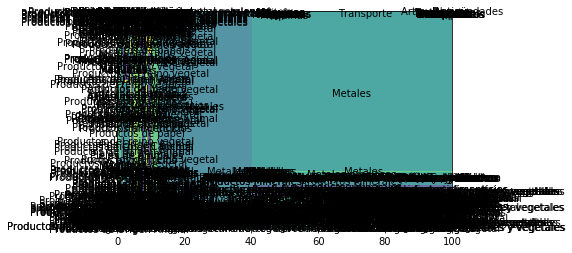

In [110]:
!pip install squarify
import matplotlib.pyplot as plt


# df = pd.DataFrame({'nb_people':[8,3,4,2], 'group':["group A", "group B", "group C", "group D"] })

casablanca = resultados.loc[["Casablanca"]]
casablanca

import squarify
squarify.plot(sizes=df['FOB US'], label=df['HS0'], alpha=.8 )

norm = matplotlib.colors.Normalize(vmin=min(dataGoals.G), vmax=max(dataGoals.G))
colors = [matplotlib.cm.Blues(norm(value)) for value in dataGoals.G]

plt.axis('off')
plt.show()